In [1]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계3 : Text classification

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * Machine Learning
>> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
> * Deep Learning
>> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
>> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
>> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)
>> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)

## 1. 개발 환경 설정

### 1-1. 라이브러리 설치

### 1-2. 라이브러리 import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
import numpy as np
import random
import os

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

seed = 42
my_seed_everywhere(seed)

### 1-4. 구글드라이브 연결(Colab)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. 데이터 불러오기

In [5]:
# data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/english.csv'
# data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/code+english_translate.csv'
data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/english_all.csv'
data = pd.read_csv(data_path)
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

data = data.replace(label_dict)
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0
1,"Currently, I dynamically create multiple forms...",1
2,Question when using glob.glob(PATH).\n\nI'm as...,0
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",0
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,0


In [24]:
import re
test_str = '안녕하세요 ! Hi !'
re.sub('[ㄱ-ㅣ가-힣]+', "", test_str)

' ! Hi !'

In [25]:
data['text'] = data['text'].apply(lambda x: re.sub('[ㄱ-ㅣ가-힣]+', "", x))
data['text'] = data['text'].apply(lambda x: re.sub('\s+', ' ', x))
data['text'] = data['text'].apply(lambda x: re.sub('\.+', '.', x))

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, 
    random_state=2023, stratify=data['label'])

## BERT

In [28]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.4 MB/s eta 0:00:00


In [29]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time
import datetime

from sklearn.metrics import confusion_matrix, classification_report

In [30]:
# Bert 용 전처리
train_sentences = ['[CLS] ' + str(s) + ' [SEP]' for s in x_train]
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
tokenized_train = [tokenizer.tokenize(s) for s in train_sentences]
ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]

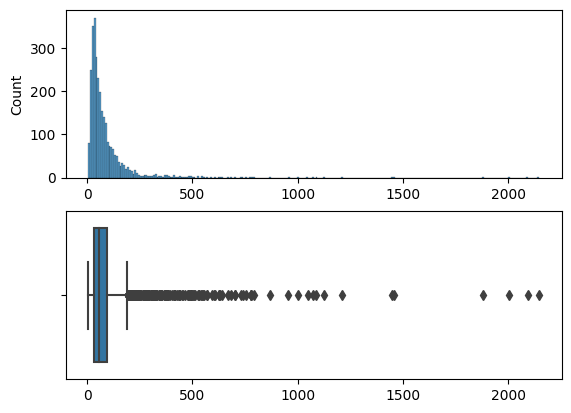

count    2964.000000
mean       88.791498
std       130.703681
min         5.000000
25%        33.000000
50%        54.000000
75%        96.250000
max      2146.000000
dtype: float64

In [31]:
temp = [len(x) for x in ids_train]
plt.subplot(2, 1, 1)
sns.histplot(temp)
plt.subplot(2, 1, 2)
sns.boxplot(x=temp)
plt.show()
pd.Series(temp).describe()

In [32]:
MAX_LEN = 200 # 최대 길이
pad_train = pad_sequences(
    ids_train, maxlen=MAX_LEN, dtype="long", padding="post", truncating="post"
)

In [33]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(pad_train, y_train.values, random_state=2023, test_size=0.1)

In [34]:
# Attention Mask 만들기
# 단어 부분은 1, 0으로 패딩된 부분은 0
attention_masks_train = []
for seq in train_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_train.append(seq_mask)

attention_masks_val = []
for seq in val_inputs:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks_val.append(seq_mask)

In [35]:
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(attention_masks_train)
train_labels = torch.tensor(train_labels)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(attention_masks_val)
val_labels = torch.tensor(val_labels)

In [36]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [37]:
## Test Set 전처리

# [CLS] + 문장 + [SEP]
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in x_test]

# 라벨 데이터
labels = y_test.values

# Word 토크나이저 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 시퀀스 설정 및 정수 인덱스 변환 & 패딩
MAX_LEN = 200
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 어텐션 마스크
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
# 파이토치 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 배치 사이즈 설정 및 데이터 설정
batch_size = 16
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [38]:
# GPU 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [39]:
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=5)
model.cuda()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [40]:
# 옵티마이저
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률(learning rate)
                  eps = 1e-8 
                )

# 에폭수
epochs = 100

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [41]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
#랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 시각화를 위한 결과 값 저장
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

## Early Stopping
best_loss = 1e9
best_acc = 0  
patience_limit = 7  # 몇 번 지켜볼지
patience_check = 0   # 현재 몇 epoch 연속으로 개선이 안되는지 기록

#그래디언트 초기화
model.zero_grad()

# 학습
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()


    # 훈련모드로 변경
    model.train()
    
    # 변수 초기화
    train_accuracy, nb_train_steps = 0, 0
    # 로스 초기화
    total_loss = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm_notebook(train_dataloader)):
        # 경과 정보 표시
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]
        logits = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_train_steps += 1

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_list.append(avg_train_loss)
    
    # 평균 정확도 계산
    avg_train_acc = train_accuracy/nb_train_steps
    train_acc_list.append(avg_train_acc)
    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.4f}".format(avg_train_acc))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    val_loss, val_accuracy = 0, 0
    nb_val_steps =  0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in tqdm_notebook(val_dataloader):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]
        # 출력 로짓 구함
        logits = outputs[1]

        # 총 로스 계산
        val_loss += loss.item()

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_val_accuracy = flat_accuracy(logits, label_ids)
        val_accuracy += tmp_val_accuracy
        nb_val_steps += 1

    # 평균 로스 계산
    avg_val_loss = val_loss / len(val_dataloader)
    val_loss_list.append(avg_val_loss)
    
    # 평균 정확도 계산
    avg_val_acc = val_accuracy/nb_val_steps
    val_acc_list.append(avg_val_acc)
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation Accuracy: {0:.4f}".format(avg_val_acc))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Early Stopping
    if avg_val_loss > best_loss: # loss 개선 되지 않은 경우
        patience_check += 1
        if patience_check >= patience_limit:
            print("Early Stopping !!!")
            break
    else: # loss 개선
        best_loss = avg_val_loss
        patience_check = 0
    # # Early Stopping
    # if avg_val_acc < best_acc: # accuracy 개선 되지 않은 경우
    #     patience_check += 1
    #     if patience_check >= patience_limit:
    #         print("Early Stopping !!!")
    #         break
    # else: # accuracy 개선
    #     best_acc = avg_val_acc
    #     patience_check = 0

print("")
print("Training complete!")


======== Epoch 1 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:33.
  Batch    40  of    167.    Elapsed: 0:01:05.
  Batch    60  of    167.    Elapsed: 0:01:38.
  Batch    80  of    167.    Elapsed: 0:02:13.
  Batch   100  of    167.    Elapsed: 0:02:48.
  Batch   120  of    167.    Elapsed: 0:03:22.
  Batch   140  of    167.    Elapsed: 0:03:56.
  Batch   160  of    167.    Elapsed: 0:04:31.

  Average training loss: 1.0251
  Average training accuracy: 0.6061
  Training epcoh took: 0:04:43

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.6146
  Validation Accuracy: 0.7738
  Validation took: 0:00:11

======== Epoch 2 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:35.
  Batch    40  of    167.    Elapsed: 0:01:09.
  Batch    60  of    167.    Elapsed: 0:01:44.
  Batch    80  of    167.    Elapsed: 0:02:18.
  Batch   100  of    167.    Elapsed: 0:02:53.
  Batch   120  of    167.    Elapsed: 0:03:27.
  Batch   140  of    167.    Elapsed: 0:04:02.
  Batch   160  of    167.    Elapsed: 0:04:37.

  Average training loss: 0.4865
  Average training accuracy: 0.8408
  Training epcoh took: 0:04:48

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.5381
  Validation Accuracy: 0.8026
  Validation took: 0:00:11

======== Epoch 3 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:35.
  Batch    40  of    167.    Elapsed: 0:01:09.
  Batch    60  of    167.    Elapsed: 0:01:44.
  Batch    80  of    167.    Elapsed: 0:02:18.
  Batch   100  of    167.    Elapsed: 0:02:53.
  Batch   120  of    167.    Elapsed: 0:03:27.
  Batch   140  of    167.    Elapsed: 0:04:02.
  Batch   160  of    167.    Elapsed: 0:04:36.

  Average training loss: 0.2518
  Average training accuracy: 0.9248
  Training epcoh took: 0:04:48

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.5970
  Validation Accuracy: 0.8395
  Validation took: 0:00:11

======== Epoch 4 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:35.
  Batch    40  of    167.    Elapsed: 0:01:09.
  Batch    60  of    167.    Elapsed: 0:01:44.
  Batch    80  of    167.    Elapsed: 0:02:18.
  Batch   100  of    167.    Elapsed: 0:02:53.
  Batch   120  of    167.    Elapsed: 0:03:27.
  Batch   140  of    167.    Elapsed: 0:04:02.
  Batch   160  of    167.    Elapsed: 0:04:36.

  Average training loss: 0.1398
  Average training accuracy: 0.9652
  Training epcoh took: 0:04:48

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.7350
  Validation Accuracy: 0.8385
  Validation took: 0:00:11

======== Epoch 5 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:35.
  Batch    40  of    167.    Elapsed: 0:01:09.
  Batch    60  of    167.    Elapsed: 0:01:44.
  Batch    80  of    167.    Elapsed: 0:02:18.
  Batch   100  of    167.    Elapsed: 0:02:53.
  Batch   120  of    167.    Elapsed: 0:03:27.
  Batch   140  of    167.    Elapsed: 0:04:02.
  Batch   160  of    167.    Elapsed: 0:04:36.

  Average training loss: 0.0845
  Average training accuracy: 0.9794
  Training epcoh took: 0:04:48

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.9026
  Validation Accuracy: 0.8370
  Validation took: 0:00:11

======== Epoch 6 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:35.
  Batch    40  of    167.    Elapsed: 0:01:09.
  Batch    60  of    167.    Elapsed: 0:01:43.
  Batch    80  of    167.    Elapsed: 0:02:18.
  Batch   100  of    167.    Elapsed: 0:02:52.
  Batch   120  of    167.    Elapsed: 0:03:27.
  Batch   140  of    167.    Elapsed: 0:04:01.
  Batch   160  of    167.    Elapsed: 0:04:36.

  Average training loss: 0.0293
  Average training accuracy: 0.9936
  Training epcoh took: 0:04:47

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.9400
  Validation Accuracy: 0.8337
  Validation took: 0:00:11

======== Epoch 7 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:35.
  Batch    40  of    167.    Elapsed: 0:01:09.
  Batch    60  of    167.    Elapsed: 0:01:43.
  Batch    80  of    167.    Elapsed: 0:02:18.
  Batch   100  of    167.    Elapsed: 0:02:52.
  Batch   120  of    167.    Elapsed: 0:03:27.
  Batch   140  of    167.    Elapsed: 0:04:01.
  Batch   160  of    167.    Elapsed: 0:04:36.

  Average training loss: 0.0355
  Average training accuracy: 0.9921
  Training epcoh took: 0:04:47

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 0.8643
  Validation Accuracy: 0.8494
  Validation took: 0:00:11

======== Epoch 8 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:35.
  Batch    40  of    167.    Elapsed: 0:01:09.
  Batch    60  of    167.    Elapsed: 0:01:44.
  Batch    80  of    167.    Elapsed: 0:02:18.
  Batch   100  of    167.    Elapsed: 0:02:53.
  Batch   120  of    167.    Elapsed: 0:03:27.
  Batch   140  of    167.    Elapsed: 0:04:02.
  Batch   160  of    167.    Elapsed: 0:04:36.

  Average training loss: 0.0159
  Average training accuracy: 0.9963
  Training epcoh took: 0:04:48

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 1.0003
  Validation Accuracy: 0.8238
  Validation took: 0:00:11

======== Epoch 9 / 100 ========
Training...


  0%|          | 0/167 [00:00<?, ?it/s]

  Batch    20  of    167.    Elapsed: 0:00:34.
  Batch    40  of    167.    Elapsed: 0:01:09.
  Batch    60  of    167.    Elapsed: 0:01:43.
  Batch    80  of    167.    Elapsed: 0:02:18.
  Batch   100  of    167.    Elapsed: 0:02:53.
  Batch   120  of    167.    Elapsed: 0:03:27.
  Batch   140  of    167.    Elapsed: 0:04:02.
  Batch   160  of    167.    Elapsed: 0:04:36.

  Average training loss: 0.0108
  Average training accuracy: 0.9978
  Training epcoh took: 0:04:48

Running Validation...


  0%|          | 0/19 [00:00<?, ?it/s]

  Validation Loss: 1.2200
  Validation Accuracy: 0.8355
  Validation took: 0:00:11
Early Stopping !!!

Training complete!


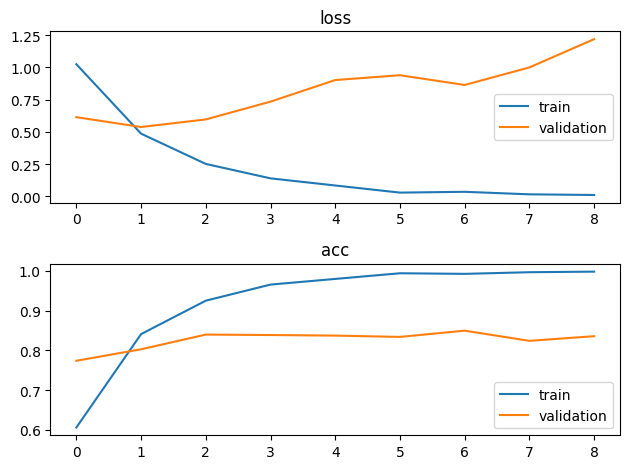

In [43]:
plt.subplot(2, 1, 1)
plt.title('loss')
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('acc')
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='validation')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
## Test Set
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 출력 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.84
Test took: 0:00:27


In [45]:
# 입력 데이터 변환
def convert_input_data(sentences):
    # [CLS] + 문장 + [SEP]
    sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 200

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

def test_sentences(sentences):
    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 출력 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [46]:
y_pred = test_sentences(x_test)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(confusion_matrix(y_test, y_pred.argmax(axis=1)))
print(classification_report(y_test, y_pred.argmax(axis=1)))
print(f1_score(y_test, y_pred.argmax(axis=1), average='macro'))

[[255  16  28  17   1]
 [  9 128   5   2   3]
 [ 20   1 117   8   0]
 [  2   5   3 102   0]
 [  0   0   0   0  20]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.85       317
           1       0.85      0.87      0.86       147
           2       0.76      0.80      0.78       146
           3       0.79      0.91      0.85       112
           4       0.83      1.00      0.91        20

    accuracy                           0.84       742
   macro avg       0.83      0.88      0.85       742
weighted avg       0.84      0.84      0.84       742

0.8491793280040391


In [48]:
save_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/save_model/'
torch.save(model, save_path + 'v2_bert_large_all_0.849.pt')